In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
from pmdarima import auto_arima
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('time_series.csv')

In [ ]:
data

,business_date,gross_sales
0,03/05/2020,275196.09
1,10/05/2020,544317.54
2,17/05/2020,483395.14
3,24/05/2020,562975.62
4,31/05/2020,531349.55
...,...,...
148,05/03/2023,634667.29
149,12/03/2023,604541.51
150,19/03/2023,599345.05
151,26/03/2023,603746.49


## Data Preprocessing

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   business_date  153 non-null    object 
 1   gross_sales    153 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [ ]:
data.describe()

,gross_sales
count,1.530000e+02
mean,5.518049e+05
std,8.620718e+04
min,2.751961e+05
25%,4.953659e+05
50%,5.442262e+05
75%,5.847786e+05
max,1.081462e+06


In [ ]:
#convert the 'business_date' column to datetime type

data['business_date'] = pd.to_datetime(data['business_date'], format='%d/%m/%Y')
data['business_date']

0     2020-05-03
1     2020-05-10
2     2020-05-17
3     2020-05-24
4     2020-05-31
         ...    
148   2023-03-05
149   2023-03-12
150   2023-03-19
151   2023-03-26
152   2023-04-02
Name: business_date, Length: 153, dtype: datetime64[ns]

In [ ]:
#set the 'business_date' as the index
data.set_index('business_date', inplace=True)

In [ ]:
data

,gross_sales
business_date,
2020-05-03,275196.09
2020-05-10,544317.54
2020-05-17,483395.14
2020-05-24,562975.62
2020-05-31,531349.55
...,...
2023-03-05,634667.29
2023-03-12,604541.51
2023-03-19,599345.05


In [ ]:
#average the weekly sales value for each month
#use start of each month as the timestamp

# y = data['gross_sales'].resample('W').mean()
# y['2020':]

## Data Visualization

In [ ]:
gross_sales = data['gross_sales']

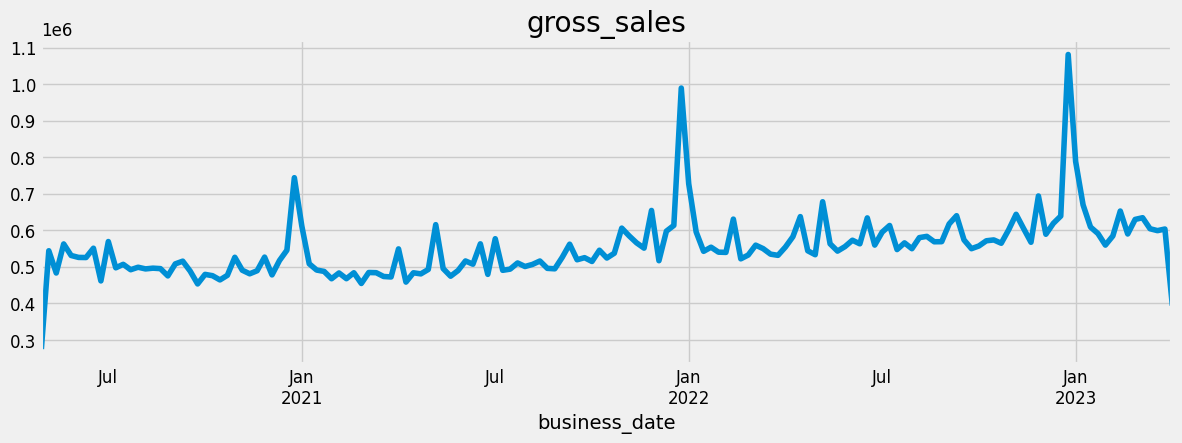

In [ ]:
import matplotlib

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

gross_sales.plot(figsize = (13, 4))
plt.title("gross_sales")

plt.show()

### Time-series decomposition

It allows us to decompose our time series into three distinct components:

* Trend
* Seasonality
* Noise



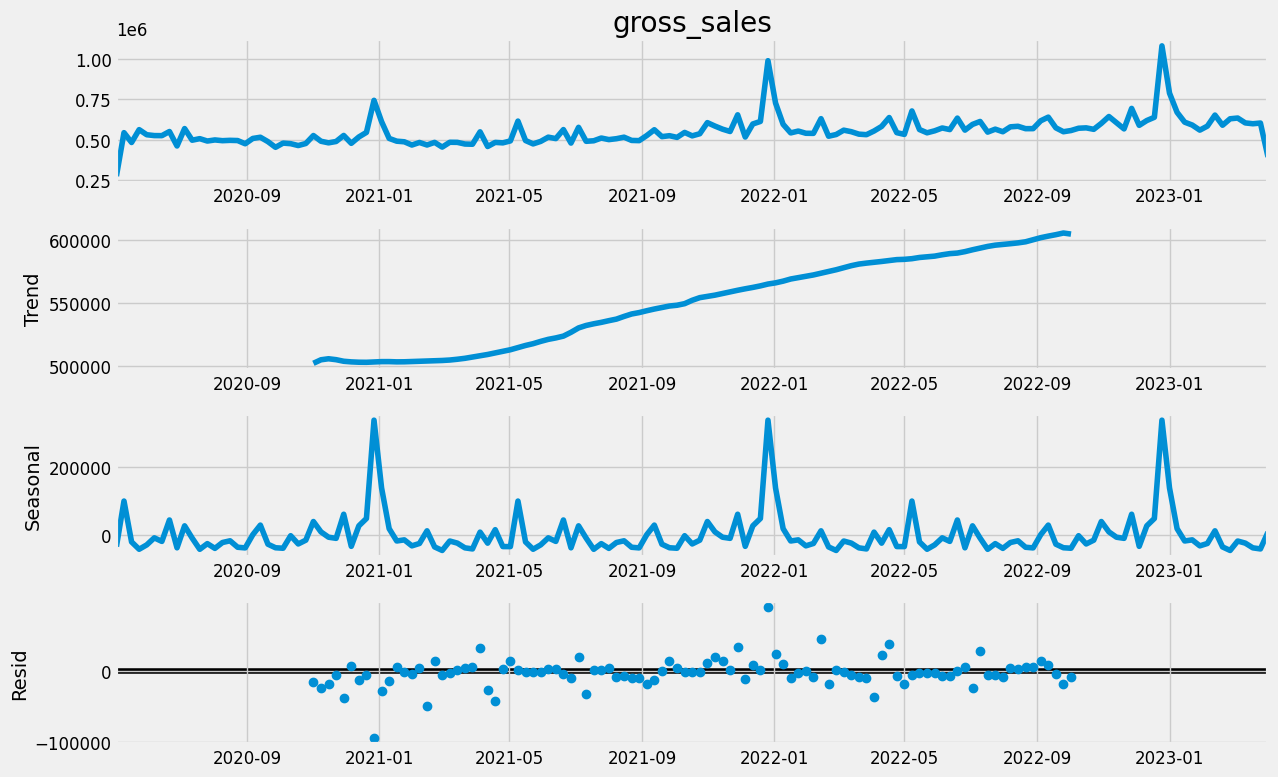

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 13, 8
decomposition = sm.tsa.seasonal_decompose(gross_sales, model = 'additive', period = 52)

fig = decomposition.plot()
plt.show()

In [ ]:
# augmented dickey-fuller test to check if the data is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['gross_sales'])

p_value = result[1]
print(p_value)

if p_value <= 0.05:
  print("The data is stationary")
else:
  print("The data is not stationary")

0.00971017676846319
The data is stationary


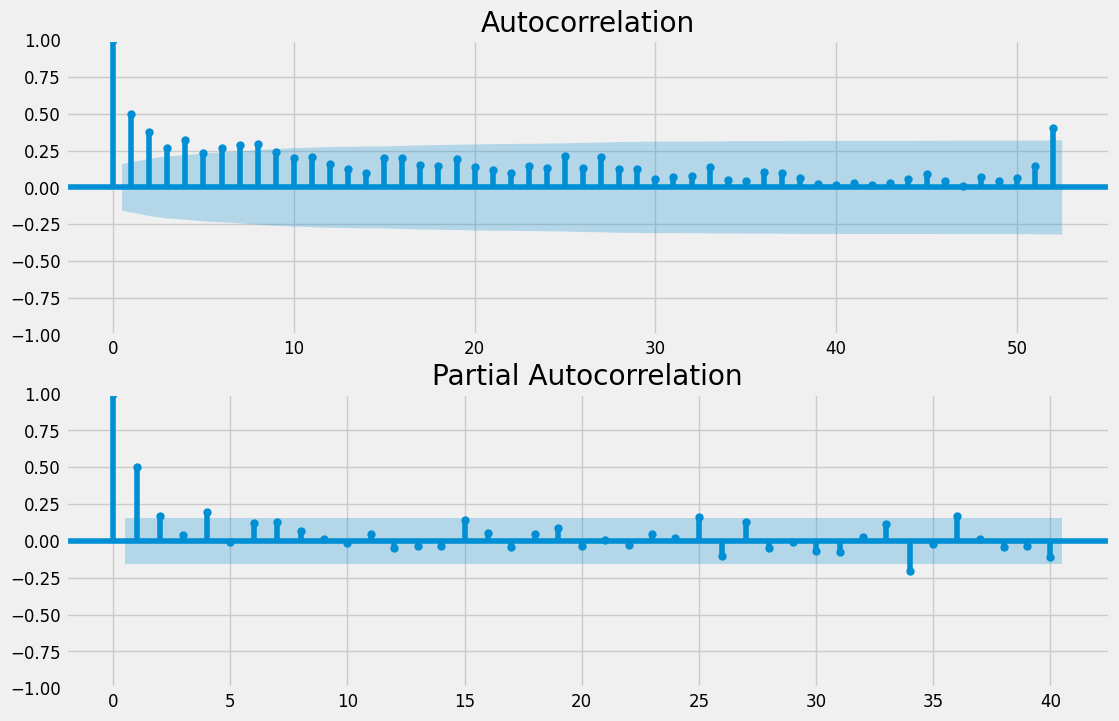

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(12,8))
#ACF plot
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=52, ax=ax1)
#PACF plot
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags = 40, ax=ax2)

## Modeling


In [ ]:
#split the data into train and test sets (80/20)

split_index = int(len(data) * 0.8)

train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

print(len(train_data))
print(len(test_data))

122
31


### SARIMAX


In [ ]:
import pmdarima as pm
from math import sqrt

stepwise_fit = pm.auto_arima(train_data, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 52, start_P = 0, seasonal=True, d=0, D=1, trace=1, error_action='ignore', suppress_warnings=True, stepwise=True)

stepwise_fit.summary()
forecast = stepwise_fit.predict(n_periods = len(test_data))

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=1703.738, Time=4.96 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1721.592, Time=0.18 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1699.060, Time=4.05 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1705.794, Time=4.57 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1788.816, Time=0.19 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1697.085, Time=0.42 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=1699.051, Time=4.47 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=1700.934, Time=10.19 sec
 ARIMA(2,0,0)(0,1,0)[52] intercept   : AIC=1700.176, Time=0.43 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1701.881, Time=0.41 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1703.795, Time=0.27 sec
 ARIMA(2,0,1)(0,1,0)[52] intercept   : AIC=1702.155, Time=0.97 sec
 ARIMA(1,0,0)(0,1,0)[52]             : AIC=1714.369, Time=0.22 sec

Best model:  ARIMA(1,0,0)(0,1,0)[52] intercept
Total fit time: 31.389 seconds


In [ ]:
#performing root mean squared error (RMSE)

from sklearn.metrics import mean_squared_error

forecasted_values = forecast.values
actual_values = test_data.values

rmse = np.sqrt(mean_squared_error(actual_values, forecasted_values))

print("RMSE:", rmse)

RMSE: 45362.48548755918


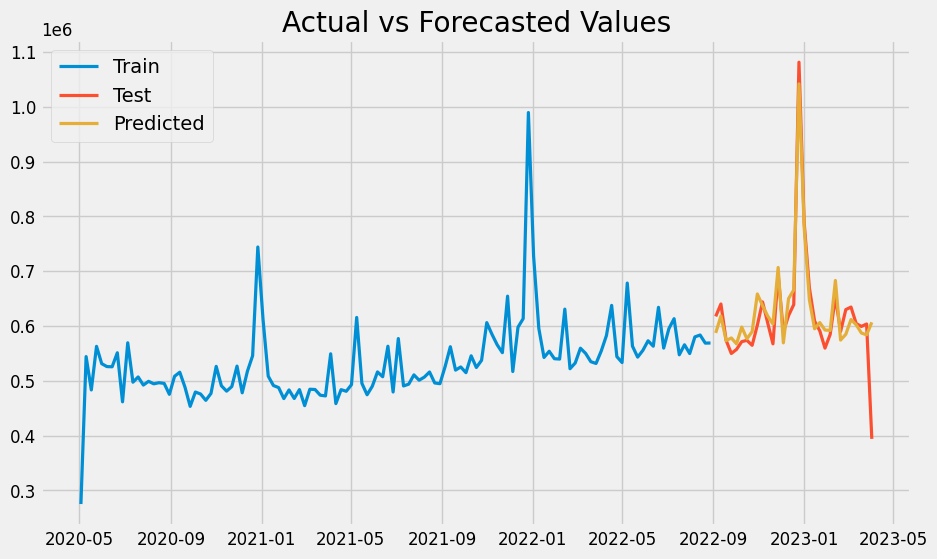

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_data.index, train_data, label="Train", linewidth=2.3)
plt.plot(test_data.index, test_data, label="Test", linewidth=2.3)
plt.plot(test_data.index, forecast, label="Predicted", linewidth=2.3)
plt.legend(loc='best')
plt.title("Actual vs Forecasted Values")
plt.show()

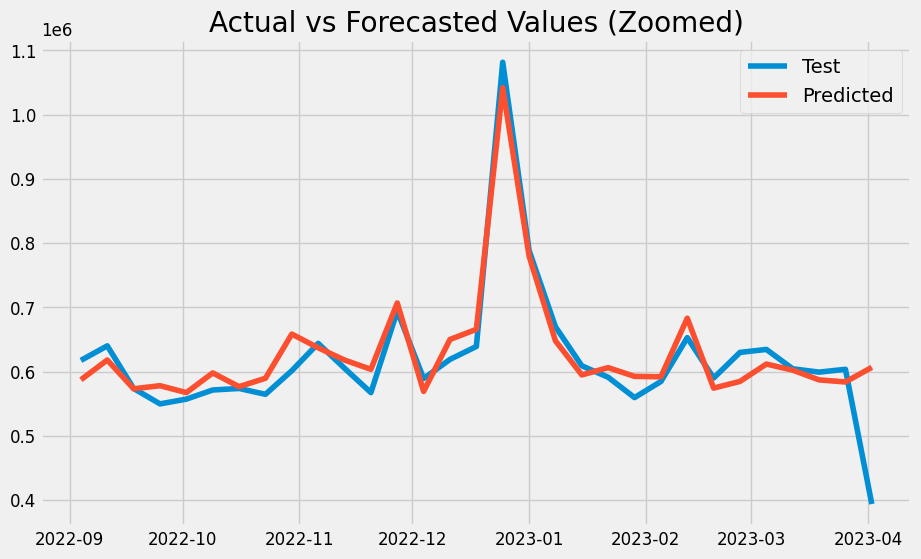

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(test_data.index, test_data, label="Test")
plt.plot(test_data.index, forecast, label="Predicted")
plt.legend(loc='best')
plt.title("Actual vs Forecasted Values (Zoomed)")
plt.show()

In [ ]:
!pip install prophet --quiet

In [ ]:
df = data.reset_index()
df.columns = ['ds', 'y']

In [ ]:
split_index  = int(len(df) * 0.8)
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

In [ ]:
from prophet import Prophet

In [ ]:
m = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.05)
m.fit(train_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp99rjcuf4/y3l6_1la.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp99rjcuf4/tzx9yb6j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76621', 'data', 'file=/tmp/tmp99rjcuf4/y3l6_1la.json', 'init=/tmp/tmp99rjcuf4/tzx9yb6j.json', 'output', 'file=/tmp/tmp99rjcuf4/prophet_modelgd6ps3uz/prophet_model-20230709215106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:51:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:51:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=len(test_data), freq='W')
forecast = m.predict(future)

In [ ]:
forecasted_values = forecast['yhat'][split_index:]
rmse = sqrt(mean_squared_error(test_data['y'], forecasted_values))
print('RMSE: ', rmse)

RMSE:  70731.90668345838


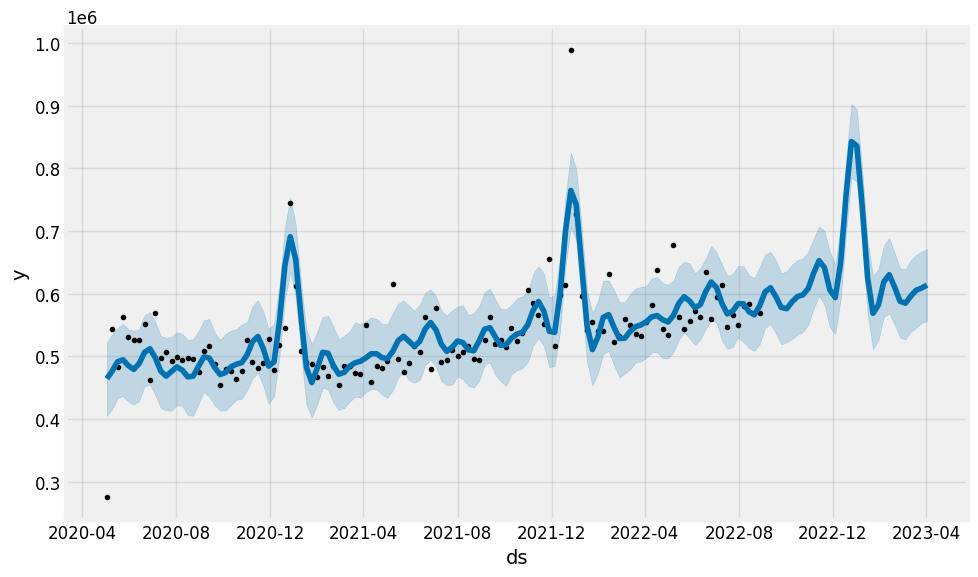

In [ ]:
m.plot(forecast)
plt.show()

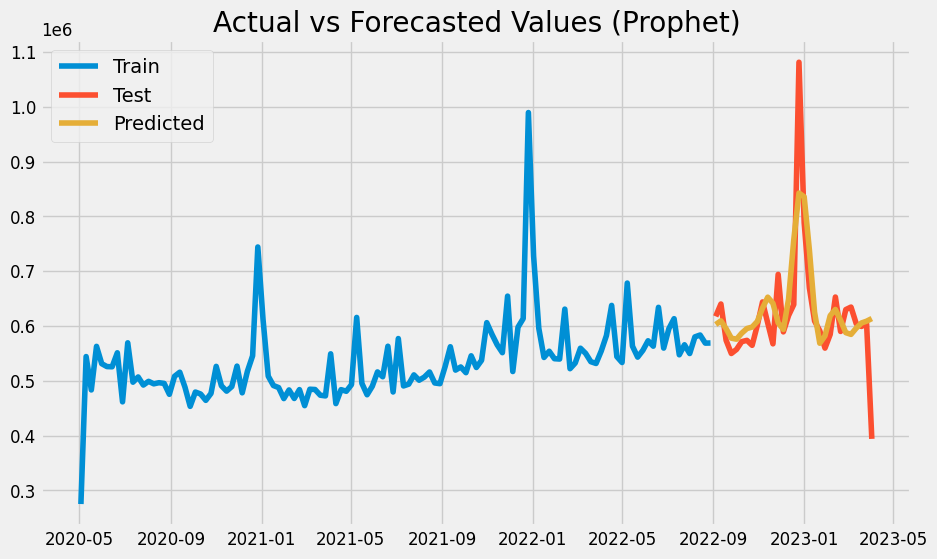

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_data['ds'], train_data['y'], label='Train')
plt.plot(test_data['ds'], test_data['y'], label='Test')
plt.plot(test_data['ds'], forecasted_values, label='Predicted')
plt.legend(loc='best')
plt.title('Actual vs Forecasted Values (Prophet)')
plt.show()

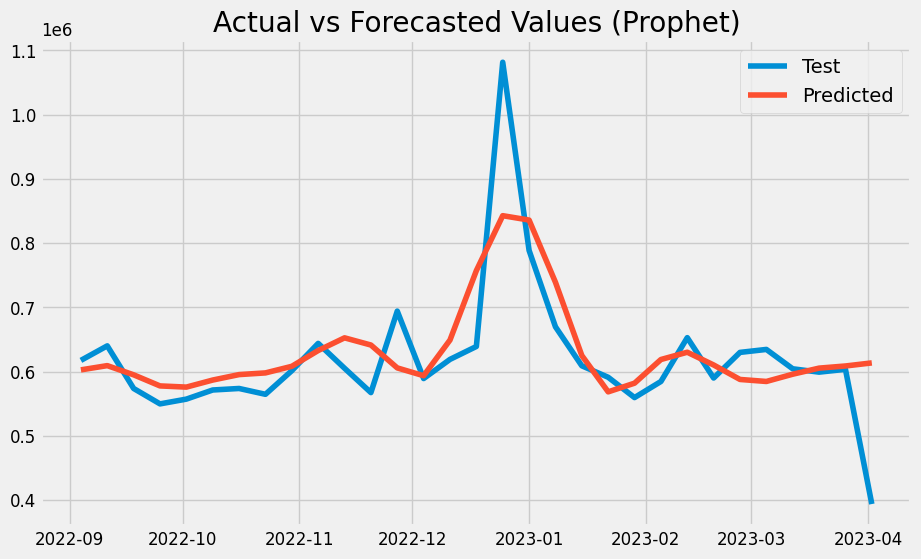

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(test_data['ds'], test_data['y'], label='Test')
plt.plot(test_data['ds'], forecasted_values, label='Predicted')
plt.legend(loc='best')
plt.title('Actual vs Forecasted Values (Prophet)')
plt.show()

In [ ]:
import pmdarima as pm
import pandas as pd

# Make sure we're using the full data to train the model
full_stepwise_fit = pm.auto_arima(data, start_p = 1, start_q = 1,
                                  max_p = 3, max_q = 3, m = 52,
                                  start_P = 0, seasonal=True,
                                  d=0, D=1, trace=1,
                                  error_action='ignore',
                                  suppress_warnings=True, stepwise=True)

# Predict the next 52 weeks
forecast = full_stepwise_fit.predict(n_periods = 52)

# Create a pandas Series with the forecast data and date index
last_date = data.index[-1]
forecast_index = pd.date_range(start=last_date, periods=53, freq='W')[1:]  # We start from the week after the last date in the data
forecast_series = pd.Series(forecast, index=forecast_index)

forecast_series


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=2455.664, Time=4.48 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=2475.963, Time=0.21 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=2452.742, Time=8.97 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=2458.649, Time=5.89 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=2560.121, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=2450.863, Time=0.44 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=2452.724, Time=7.91 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=2454.671, Time=8.58 sec
 ARIMA(2,0,0)(0,1,0)[52] intercept   : AIC=2453.544, Time=0.44 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=2454.349, Time=0.50 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=2456.957, Time=0.35 sec
 ARIMA(2,0,1)(0,1,0)[52] intercept   : AIC=2455.358, Time=0.91 sec
 ARIMA(1,0,0)(0,1,0)[52]             : AIC=2470.710, Time=0.25 sec

Best model:  ARIMA(1,0,0)(0,1,0)[52] intercept
Total fit time: 39.114 seconds


2023-04-09    5.494373e+05
2023-04-16    6.543252e+05
2023-04-23    5.803944e+05
2023-04-30    5.773003e+05
2023-05-07    7.253286e+05
2023-05-14    6.113831e+05
2023-05-21    5.918205e+05
2023-05-28    6.043315e+05
2023-06-04    6.219111e+05
2023-06-11    6.120425e+05
2023-06-18    6.830165e+05
2023-06-25    6.085812e+05
2023-07-02    6.440885e+05
2023-07-09    6.622666e+05
2023-07-16    5.963839e+05
2023-07-23    6.146786e+05
2023-07-30    5.986763e+05
2023-08-06    6.290559e+05
2023-08-13    6.324667e+05
2023-08-20    6.176785e+05
2023-08-27    6.179104e+05
2023-09-03    6.664612e+05
2023-09-10    6.890642e+05
2023-09-17    6.227439e+05
2023-09-24    5.987763e+05
2023-10-01    6.061834e+05
2023-10-08    6.203868e+05
2023-10-15    6.227393e+05
2023-10-22    6.136707e+05
2023-10-29    6.504155e+05
2023-11-05    6.928772e+05
2023-11-12    6.541973e+05
2023-11-19    6.163463e+05
2023-11-26    7.431084e+05
2023-12-03    6.382070e+05
2023-12-10    6.680004e+05
2023-12-17    6.880794e+05
2

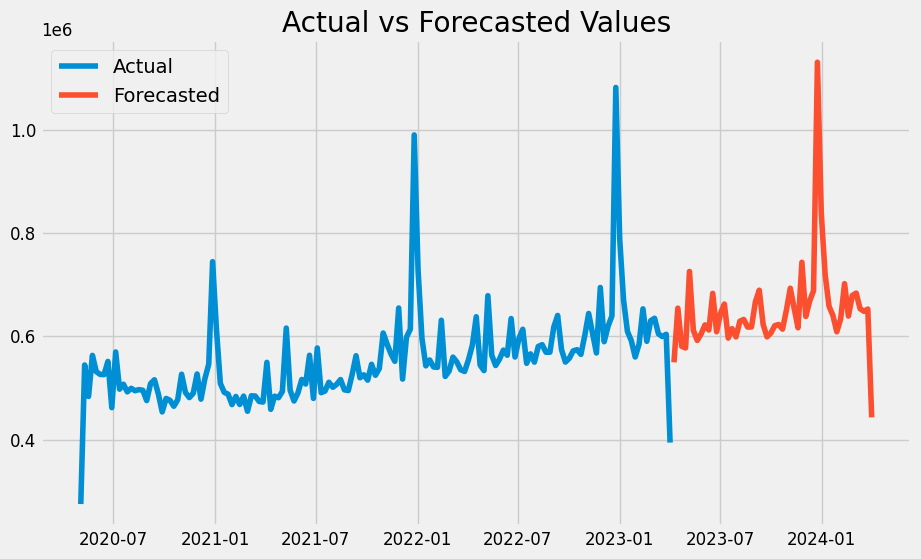

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data['gross_sales'], label='Actual')
plt.plot(forecast_series.index, forecast_series, label='Forecasted')
plt.legend(loc='best')
plt.title('Actual vs Forecasted Values')
plt.show()

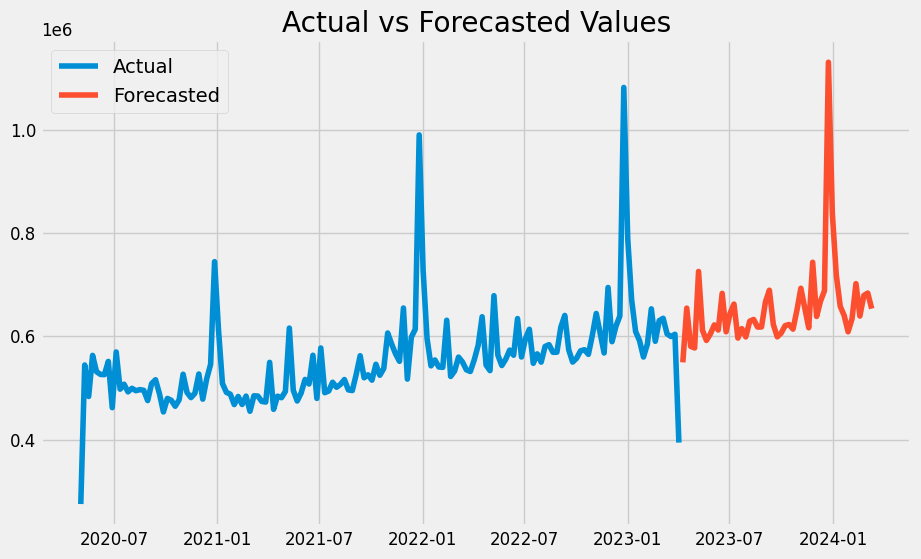

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data['gross_sales'], label='Actual')
plt.plot(forecast_series.index[:-3], forecast_series[:-3], label='Forecasted')
plt.legend(loc='best')
plt.title('Actual vs Forecasted Values')
plt.show()


In [ ]:
forecast_df = forecast_series.reset_index()
forecast_df.columns = ['Date', 'Forecasted_sales']
forecast_df.to_csv('forecasted_sales.csv', index=False)

In [ ]:
mean_sales = forecast_df['Forecasted_sales'].mean()
median_sales = forecast_df['Forecasted_sales'].median()

mean_sales, median_sales

(649065.5319292212, 635901.010562319)

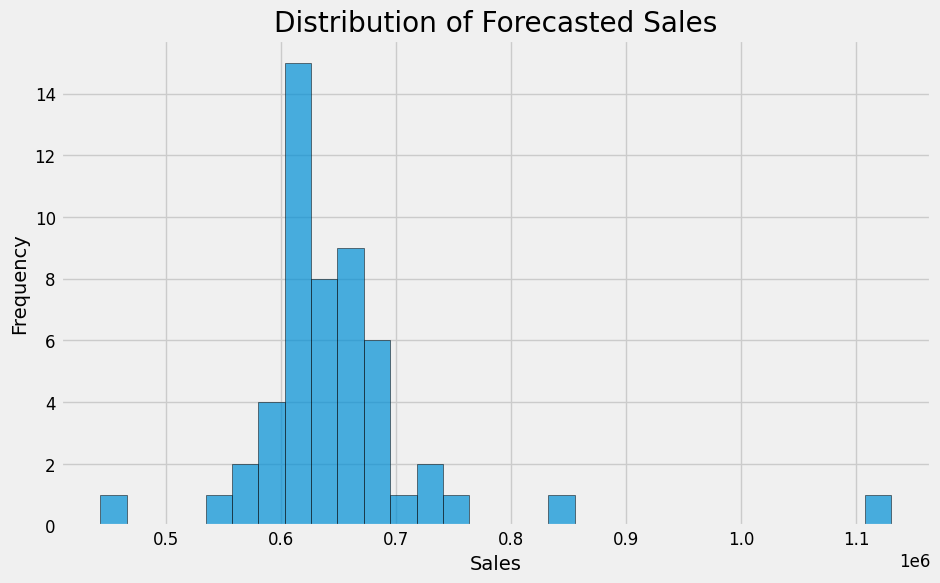

In [ ]:
# Create a histogram to visualize the distribution of sales
plt.figure(figsize=(10, 6))
plt.hist(forecast_df['Forecasted_sales'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Forecasted Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
